In [1]:
from vae.test import hello
hello()

World!


In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from vae.models import LeNeT5Encoder, LeNeT5Decoder
from vae.losses import KLDivergence

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
dataset = datasets.MNIST(
    '../data', 
    train=True, 
    download=True,
    transform=transform,
    )
test = datasets.MNIST(
    '../data', 
    train=False, 
    download=True,
    transform=transform,
)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=16)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=16)

In [5]:
dataset[0][0].shape

torch.Size([1, 28, 28])

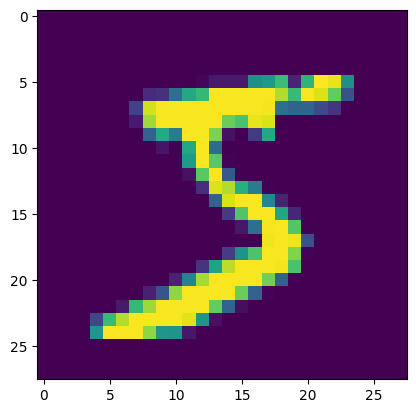

In [6]:
import matplotlib.pyplot as plt


plt.imshow(dataset[0][0].squeeze(0))

In [7]:
dataset[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [8]:
encoder = LeNeT5Encoder()
decoder = LeNeT5Decoder()

In [9]:
from torch.optim import SGD
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR


#optimizer = AdamW([*encoder.parameters(), *decoder.parameters()], lr=0.002)

# TODO: do not regularize biases
from adabelief_pytorch import AdaBelief
optimizer = AdaBelief(
    [*encoder.parameters(), *decoder.parameters()], 
    lr=2e-2,
    eps=1e-8,
    betas=(0.9,0.999), 
    weight_decouple = True, 
    rectify = False)

scheduler = CosineAnnealingLR(optimizer, T_max=4*60000/16)

loss = torch.nn.SmoothL1Loss()

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief


In [10]:
for epoch in range(1):
    for batch_idx, (data, target) in enumerate(dataloader):
        latents = encoder(data)
        outs = decoder(latents)

        loss_value = loss(data, outs)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        print(loss_value.item())

0.0648094117641449
0.04097887873649597
0.0463249571621418
0.04105045273900032
0.037179626524448395
0.04451703652739525
0.03341028094291687
0.03926204890012741
0.031223241239786148
0.036504220217466354
0.0325981043279171
0.034482717514038086
0.034938015043735504
0.04050150513648987
0.034462787210941315
0.03857486695051193
0.028946608304977417
0.03657785803079605
0.03622782975435257
0.03147308528423309
0.03518974408507347
0.031378019601106644
0.030724724754691124
0.03190591558814049
0.03327587619423866
0.02978532388806343
0.03377309441566467
0.03295102342963219
0.03586317226290703
0.03387190401554108
0.03479422256350517
0.030034709721803665
0.03783227875828743
0.030972518026828766
0.032959140837192535
0.03126189112663269
0.030727539211511612
0.03242815285921097
0.03416068106889725
0.030538257211446762
0.030987048521637917
0.03784235194325447
0.03205252066254616
0.03370846062898636
0.03579837456345558
0.03642966225743294
0.033811770379543304
0.03531710058450699
0.032628629356622696
0.0334

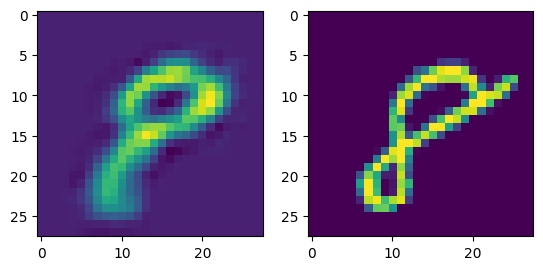

In [11]:
fig, axes = plt.subplots(1, 2)
n = 15
axes[0].imshow(outs[n, 0, :, :].detach().numpy())
axes[1].imshow(data[n, 0, :, :].detach().numpy())

In [12]:
from collections import defaultdict
test_losses = defaultdict(list)

test_loss = torch.nn.SmoothL1Loss(reduction='none')
for batch_idx, (data, target) in enumerate(test_dataloader):
    latents = encoder(data)

    outs = decoder(latents)
    loss_value = test_loss(data, outs).detach().mean(dim=(1, 2, 3,)).numpy()
    for t, diff in zip(target, loss_value):
        test_losses[t.item()].append(diff)

0.011254852


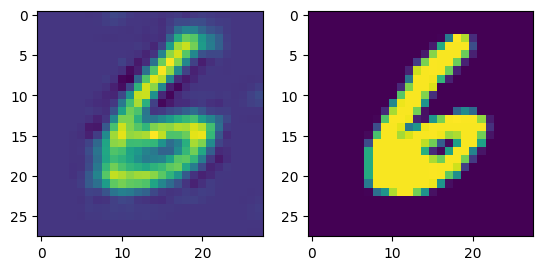

In [13]:
fig, axes = plt.subplots(1, 2)
n = 5
print(test_loss(outs, data).detach().mean(dim=(1, 2, 3,))[n].numpy())
axes[0].imshow(outs[n, 0, :, :].detach().numpy())
axes[1].imshow(data[n, 0, :, :].detach().numpy())

0.003409007 0.026278483
0.0049916203 0.053616177
0.0017898896 0.018343464
0.0048441766 0.06564648
0.0041739116 0.032211404
0.0043704784 0.033210076
0.0046824142 0.034097467
0.004387448 0.04740926
0.0043399916 0.05195783
0.0059699314 0.049179874


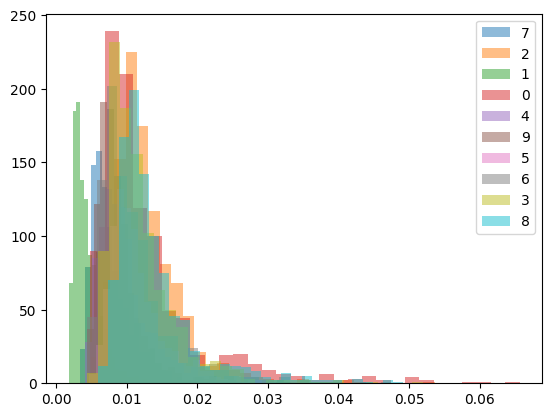

In [14]:
import matplotlib.pyplot as plt


for k, v in test_losses.items():
    print(min(v), max(v))
    plt.hist(v, label=k, alpha = 0.5, bins=30)
plt.legend()

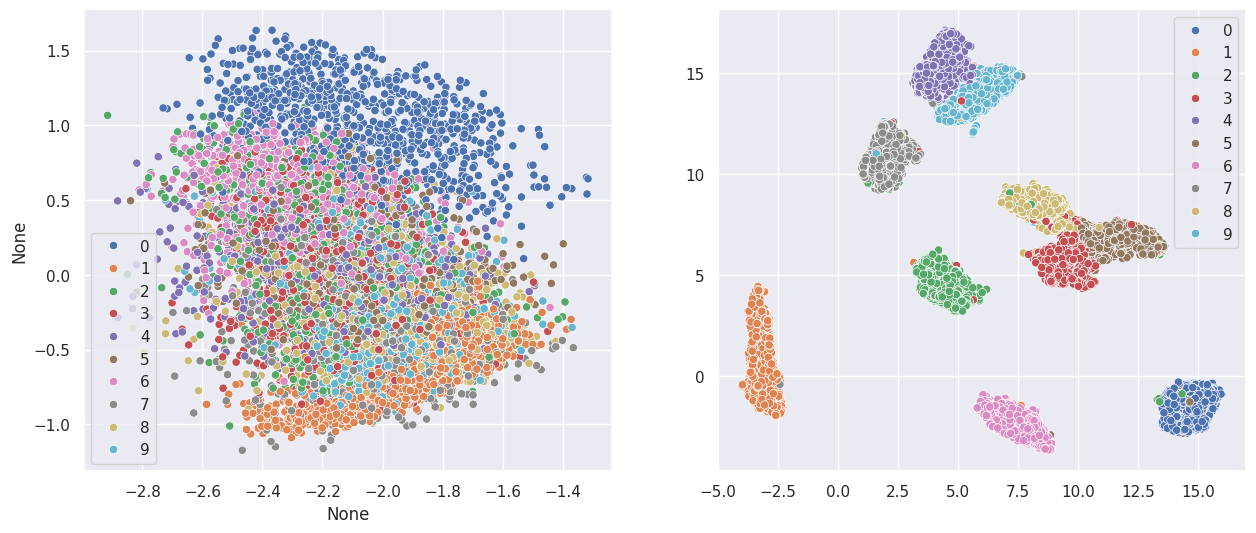

In [16]:
from scipy.linalg import svd
import seaborn as sns
import umap

sns.set_theme()


fig, axes = plt.subplots(1, 2, figsize=(15, 6))
with torch.no_grad():

    latents_list = []
    targets_list = []
    for batch_idx, (data, target) in enumerate(test_dataloader):
        latent = encoder(data)
        latents_list.append(latent)
        targets_list.extend(target.tolist())


    latents = torch.cat(latents_list)
    u, s, vt = latents.svd()
    pc = u[:, :2] @ s[:2].diag()

    fit = umap.UMAP()
    umap2d = fit.fit_transform(latents)
    sns.scatterplot(x=pc[:, 0], y=pc[:, 1], hue=targets_list, palette="deep", ax=axes[0])
    sns.scatterplot(x=umap2d[:, 0], y=umap2d[:, 1], hue=targets_list, palette="deep", ax=axes[1])

In [61]:
encoder = LeNeT5Encoder()
decoder = LeNeT5Decoder()
mus_layer = nn.Sequential(nn.Linear(84, 84))
classifier = nn.Linear(84, 10)
log_sigmas_layer = nn.Linear(84, 84)
# log_sigmas_layer.bias.data -= 0.01
# torch.nn.init.kaiming_normal(log_sigmas_layer.weight * 0.01)

from vae.losses import DoubleKLDivergence
from vae.losses import KLDivergence

kl_div = KLDivergence()

import torch.nn.functional as F
from torchvision.ops.focal_loss import sigmoid_focal_loss
from adabelief_pytorch import AdaBelief
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR


# TODO: experiment with sampler. Sample digits with the same labels in a batch
# TODO: do not regularize biases
optimizer = AdaBelief(
    [
        *encoder.parameters(), 
        *log_sigmas_layer.parameters(), 
        *mus_layer.parameters(), 
        *classifier.parameters(),
        *decoder.parameters(), 
    ], 
    lr=6e-3,
    eps=1e-8,
    betas=(0.9,0.99), 
    weight_decouple = True, 
    rectify = False)
# optimizer = AdamW(
#     [
#         *encoder.parameters(), 
#         *mus_layer.parameters(), 
#         *log_sigmas_layer.parameters(), 
#         *decoder.parameters(), 
#     ],  
#     lr=6e-3,
# )

scheduler = CosineAnnealingLR(optimizer, T_max=1*60000/16)
#loss = torch.nn.BCEWithLogitsLoss(reduction='mean')
#loss = lambda x, y: sigmoid_focal_loss(x, y, reduction='mean')
loss = torch.nn.SmoothL1Loss()
classifier_loss = torch.nn.CrossEntropyLoss()

def sample_z(mus, log_sigmas):
    eps = torch.normal(0, 1, mus.shape)
    sigma = (0.5*log_sigmas).exp()
    assert (sigma >= -0.0).all(), f"{sigma[sigma < 0]}"

    # print(mus.shape, sigma.shape)
    return mus + sigma * eps

import math
kl_losses = []
for epoch in range(4):
    for batch_idx, (data, target) in enumerate(dataloader):
        latents = encoder(data)
        mus = mus_layer(latents)
        log_sigmas = log_sigmas_layer(latents)
        generated_samples = sample_z(mus, log_sigmas)
        classifier_logits = classifier(generated_samples)

        outs = decoder(generated_samples)
        # print(log_sigmas[0, :3], log_sigmas[0, :3].exp(), mus[0, :3].pow(2))
        reconstruction_loss = loss(outs, data)
        #sigmoid_anneal = 0.3 - 0.3 / (1.0 + torch.exp(16/60000*torch.tensor(batch_idx + batch_idx * epoch)))
        #print(sigmoid_anneal)
        kl_loss = kl_div(mus, log_sigmas)
        kl_losses.append(kl_loss.item())
        loss_value = reconstruction_loss + math.log(batch_idx + batch_idx * epoch + 1) / 100000 * kl_loss + 0.0001 * classifier_loss(classifier_logits, target)
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        #scheduler
        print(f"{kl_loss.item():.4f}", f"{reconstruction_loss.item():.4f}", f"{loss_value.item():.4f}")

Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.

Weight decoupling enabled in AdaBelief
0.6675 0.4389 0.4391
0.7928 0.3627 0.3630
0.8802 0.3149 0.3152
1.1736 0.3143 0

KeyboardInterrupt: 

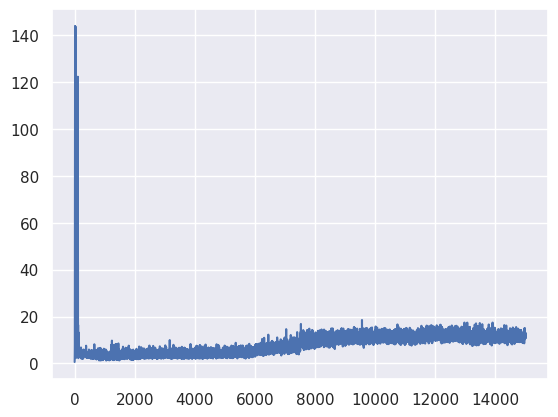

In [55]:
plt.plot(kl_losses)

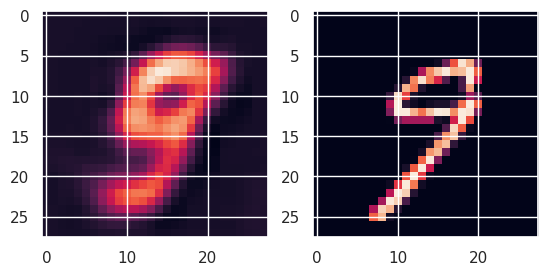

In [57]:
fig, axes = plt.subplots(1, 2)

n = 8
axes[0].imshow(outs[n, 0, :, :].detach().numpy())
axes[1].imshow(data[n, 0, :, :].detach().numpy())

/home/aakonix/workspace/vae/.venv/lib/python3.11/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


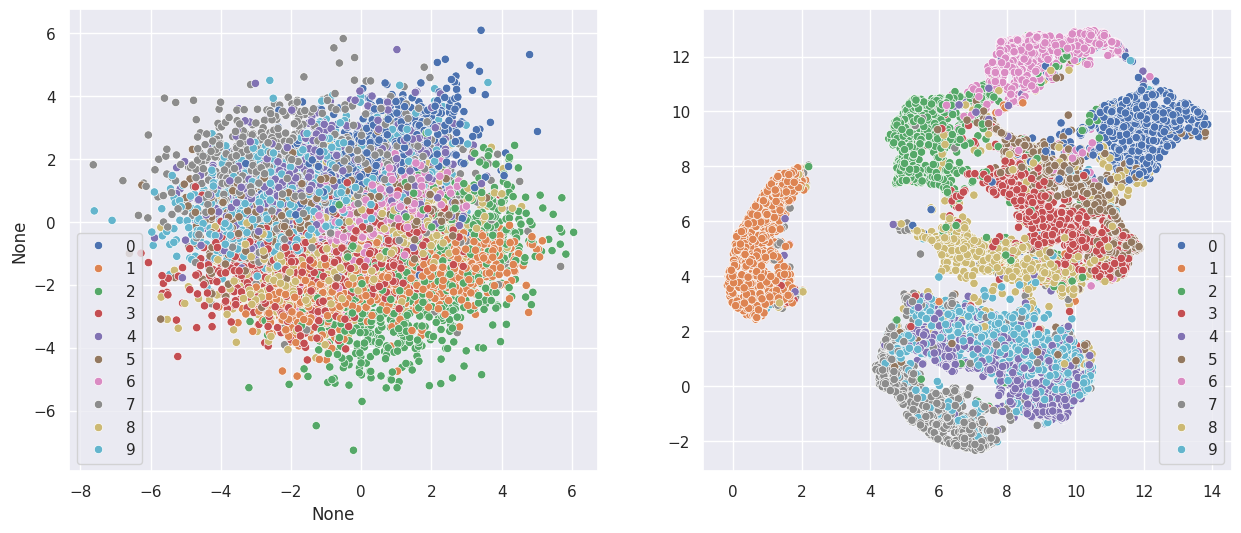

In [58]:
import seaborn as sns
import umap

sns.set_theme()


fig, axes = plt.subplots(1, 2, figsize=(15, 6))
with torch.no_grad():

    latents_list = []
    targets_list = []
    for batch_idx, (data, target) in enumerate(test_dataloader):
        latent = encoder(data)
        mus = mus_layer(latent)
        latents_list.append(mus)
        targets_list.extend(target.tolist())


    latents = torch.cat(latents_list)
    u, s, vt = latents.svd()
    pc = u[:, :2] @ s[:2].diag()

    fit = umap.UMAP()
    umap2d = fit.fit_transform(latents)
    sns.scatterplot(x=pc[:, 0], y=pc[:, 1], hue=targets_list, palette="deep", ax=axes[0])
    sns.scatterplot(x=umap2d[:, 0], y=umap2d[:, 1], hue=targets_list, palette="deep", ax=axes[1])

tensor(2)


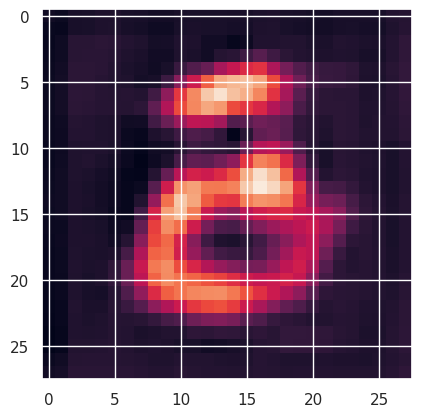

In [53]:
z = torch.normal(0, 1, (1, 84))
print(classifier(z).argmax())
out = decoder(z)
plt.imshow(out[0, 0, :, :].detach().numpy())